In [2]:
## Setup and Imports ##
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from datetime import datetime
from pypfopt.expected_returns import mean_historical_return
from pypfopt.risk_models import sample_cov
from pypfopt import EfficientFrontier, objective_functions

In [3]:
## Ticker List and Data Download ##

# BIST 30 tickers (updated as needed)
tickers = [
    "AKBNK.IS", "ARCLK.IS", "ASELS.IS", "ASTOR.IS", "BIMAS.IS", "DOHOL.IS", "EKGYO.IS",
    "EUPWR.IS", "FROTO.IS", "GARAN.IS", "GUBRF.IS", "HEKTS.IS", "ISCTR.IS", "KCHOL.IS",
    "KRDMD.IS", "KOZAA.IS", "KOZAL.IS", "ODAS.IS", "PETKM.IS", "PGSUS.IS", "SAHOL.IS",
    "SASA.IS", "SISE.IS", "SMRTG.IS", "TAVHL.IS", "TCELL.IS", "THYAO.IS", "TOASO.IS",
    "TUPRS.IS", "YKBNK.IS"
]

# Download historical data (Adjusted Close prices)
data = yf.download(tickers, start="2020-01-01", end="2025-07-01", auto_adjust=True)["Close"]

# Data cleaning
data = data.replace(0, np.nan).dropna(how="any", axis=0)


[*********************100%***********************]  30 of 30 completed


<Figure size 1400x600 with 0 Axes>

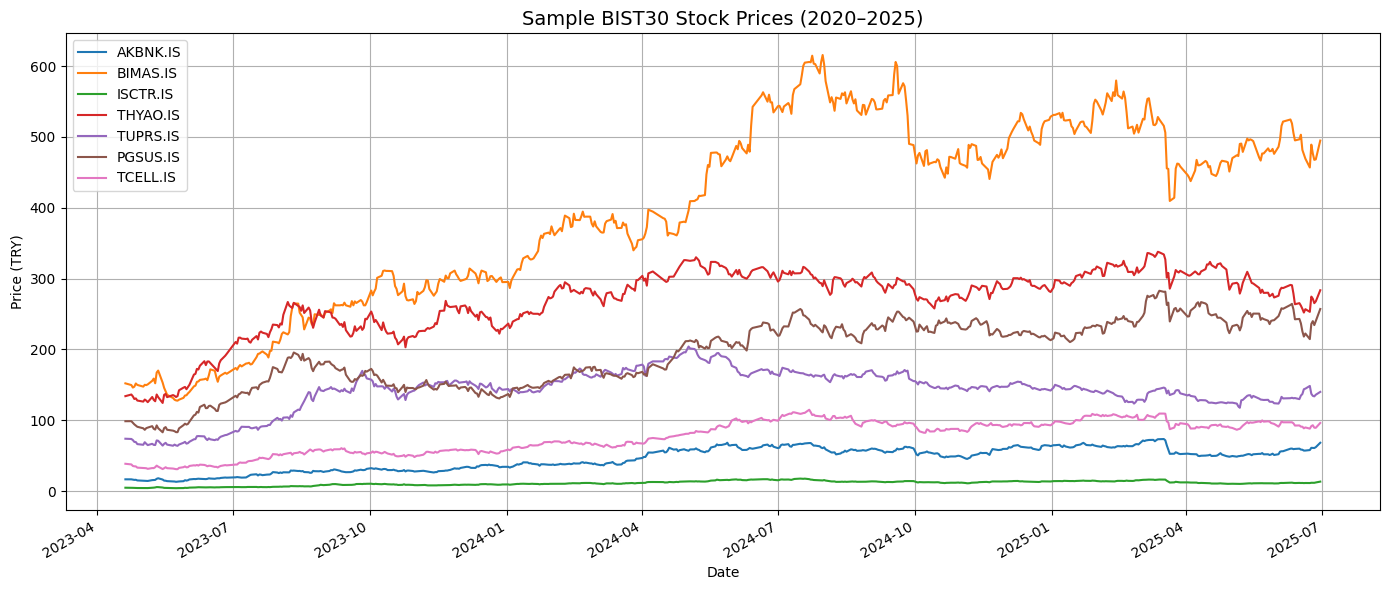

In [4]:
## EDA and Visualization ##
import matplotlib.pyplot as plt

# Plotting the price history of a few sample stocks from the BIST30
sample_tickers = ["AKBNK.IS", "BIMAS.IS", "ISCTR.IS", "THYAO.IS", "TUPRS.IS", "PGSUS.IS", "TCELL.IS"]

plt.figure(figsize=(14, 6))
data[sample_tickers].plot(figsize=(14, 6))
plt.title("Sample BIST30 Stock Prices (2020–2025)", fontsize=14)
plt.xlabel("Date")
plt.ylabel("Price (TRY)")
plt.grid(True)
plt.legend(loc="upper left")
plt.tight_layout()
plt.show()

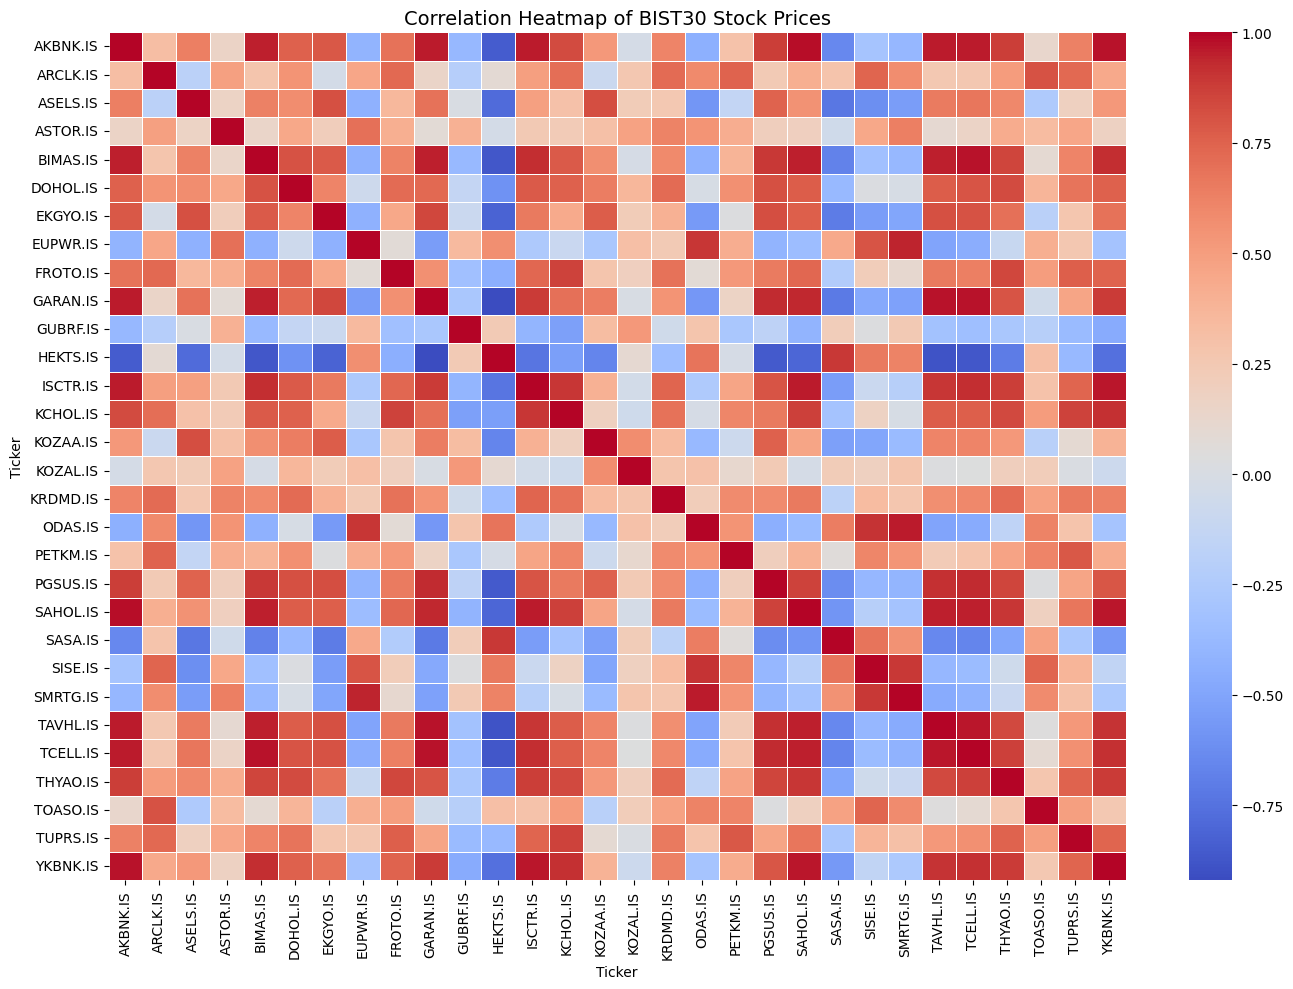

In [5]:
import seaborn as sns

# Correlation matrix
corr_matrix = data.corr()

plt.figure(figsize=(14, 10))
sns.heatmap(corr_matrix, annot=False, cmap="coolwarm", linewidths=0.5)
plt.title("Correlation Heatmap of BIST30 Stock Prices", fontsize=14)
plt.tight_layout()
plt.show()

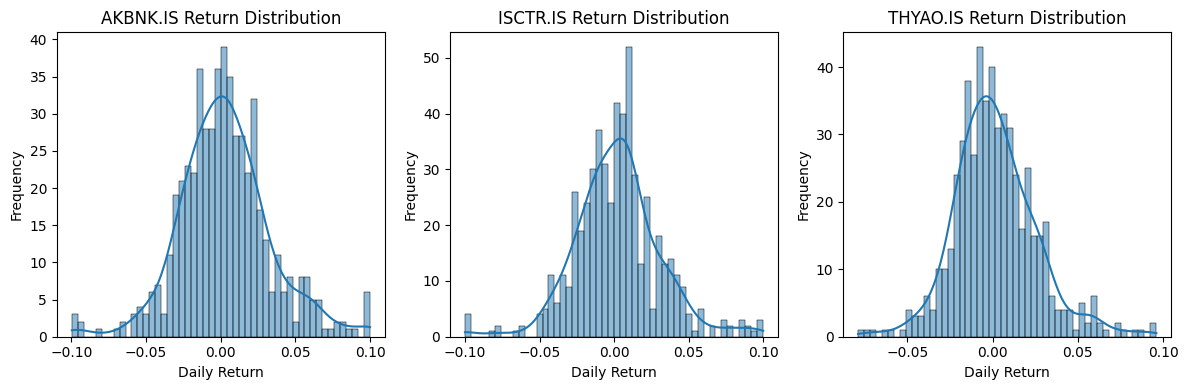

In [6]:
# Daily returns calculation
daily_returns = data.pct_change().dropna()

# Plot histogram for a few selected stocks
sample_tickers = ["AKBNK.IS", "ISCTR.IS", "THYAO.IS"]

plt.figure(figsize=(12, 4))
for i, ticker in enumerate(sample_tickers):
    plt.subplot(1, 3, i + 1)
    sns.histplot(daily_returns[ticker], bins=50, kde=True)
    plt.title(f"{ticker} Return Distribution")
    plt.xlabel("Daily Return")
    plt.ylabel("Frequency")

plt.tight_layout()
plt.show()


In [7]:
## Expected Returns and Covariance Matrix ##

from pypfopt.expected_returns import mean_historical_return
from pypfopt.risk_models import sample_cov

# Calculation of annualized expected returns and sample covariance matrix of asset returns
mu = mean_historical_return(data)
S = sample_cov(data)

# Display of first few values
print("Expected Annual Returns:")
print(mu.head())

print("\nCovariance Matrix (partial):")
print(S.iloc[:5, :5])


Expected Annual Returns:
Ticker
AKBNK.IS    0.924744
ARCLK.IS    0.038528
ASELS.IS    1.258605
ASTOR.IS    0.311653
BIMAS.IS    0.727246
dtype: float64

Covariance Matrix (partial):
Ticker    AKBNK.IS  ARCLK.IS  ASELS.IS  ASTOR.IS  BIMAS.IS
Ticker                                                    
AKBNK.IS  0.234781  0.081801  0.066253  0.055389  0.085128
ARCLK.IS  0.081801  0.159491  0.068973  0.079958  0.067745
ASELS.IS  0.066253  0.068973  0.191447  0.072352  0.052424
ASTOR.IS  0.055389  0.079958  0.072352  0.277685  0.065693
BIMAS.IS  0.085128  0.067745  0.052424  0.065693  0.171831


C:\Users\USER\AppData\Local\Temp\ipykernel_23380\1666511151.py:18: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.annotate(txt, (returns_risk["Volatility"][i], returns_risk["Expected Return"][i]), fontsize=8)


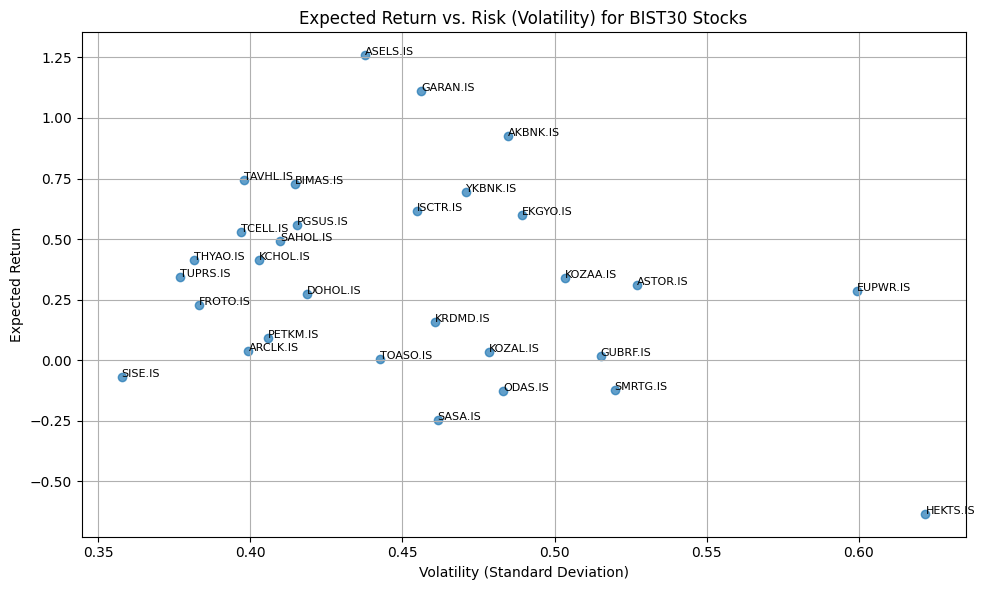

In [8]:
## Visualizing Expected Returns and Risk ##

# Calculating the risk (volatility) from the diagonal of the covariance matrix
volatility = np.sqrt(np.diag(S.values))  # <-- FIXED

# Combine into a DataFrame for display
returns_risk = pd.DataFrame({
    "Expected Return": mu,
    "Volatility": volatility
}, index=mu.index)


# Plot return vs. risk
plt.figure(figsize=(10, 6))
plt.scatter(returns_risk["Volatility"], returns_risk["Expected Return"], alpha=0.7)

for i, txt in enumerate(returns_risk.index):
    plt.annotate(txt, (returns_risk["Volatility"][i], returns_risk["Expected Return"][i]), fontsize=8)

plt.xlabel("Volatility (Standard Deviation)")
plt.ylabel("Expected Return")
plt.title("Expected Return vs. Risk (Volatility) for BIST30 Stocks")
plt.grid(True)
plt.tight_layout()
plt.show()


In [22]:
## Markowitz Optimization (Efficient Frontier) ##

from pypfopt import EfficientFrontier, risk_models, expected_returns, plotting
from pypfopt.discrete_allocation import DiscreteAllocation, get_latest_prices

# Calculating expected returns and sample covariance
mu = mean_historical_return(data)
S = risk_models.sample_cov(data)

# Optimizing for max Sharpe Ratio
from pypfopt import objective_functions

ef = EfficientFrontier(mu, S, weight_bounds=(0, 0.30))  # 1%–30% constraint
ef.add_objective(objective_functions.L2_reg, gamma=0.1)     # smooth allocations
weights = ef.max_sharpe()
cleaned_weights = ef.clean_weights()

# Optional: view performance
ret, vol, sharpe = ef.portfolio_performance(verbose=True)

print("Optimal Weights:\n", cleaned_weights)

# Portfolio performance
performance = ef.portfolio_performance(verbose=True)

Expected annual return: 101.5%
Annual volatility: 31.8%
Sharpe Ratio: 3.19
Optimal Weights:
 OrderedDict([('AKBNK.IS', 0.0747), ('ARCLK.IS', 0.0), ('ASELS.IS', 0.3), ('ASTOR.IS', 0.0), ('BIMAS.IS', 0.14961), ('DOHOL.IS', 0.0), ('EKGYO.IS', 0.0063), ('EUPWR.IS', 0.0), ('FROTO.IS', 0.0), ('GARAN.IS', 0.29057), ('GUBRF.IS', 0.0), ('HEKTS.IS', 0.0), ('ISCTR.IS', 0.0), ('KCHOL.IS', 0.0), ('KOZAA.IS', 0.0), ('KOZAL.IS', 0.0), ('KRDMD.IS', 0.0), ('ODAS.IS', 0.0), ('PETKM.IS', 0.0), ('PGSUS.IS', 0.0), ('SAHOL.IS', 0.0), ('SASA.IS', 0.0), ('SISE.IS', 0.0), ('SMRTG.IS', 0.0), ('TAVHL.IS', 0.17881), ('TCELL.IS', 0.0), ('THYAO.IS', 0.0), ('TOASO.IS', 0.0), ('TUPRS.IS', 0.0), ('YKBNK.IS', 0.0)])
Expected annual return: 101.5%
Annual volatility: 31.8%
Sharpe Ratio: 3.19


C:\Users\USER\AppData\Roaming\Python\Python39\site-packages\pypfopt\efficient_frontier\efficient_frontier.py:259: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  warnings.warn(


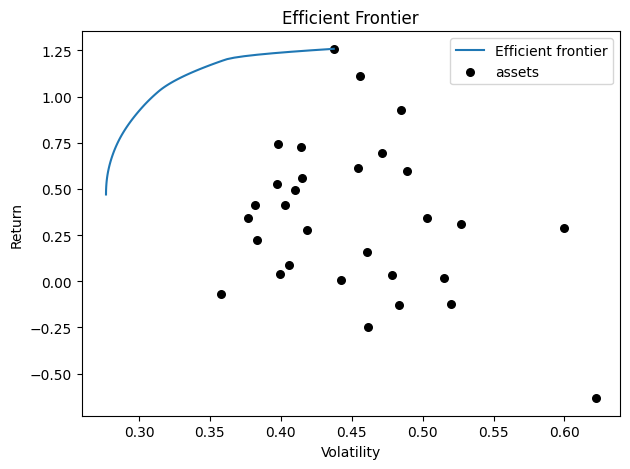

In [23]:
## EF Visualization ##

# Re-createting the EfficientFrontier instance just for plotting purposes
ef_plot = EfficientFrontier(mu, S)

# Plot Efficient Frontier
from pypfopt import plotting
import matplotlib.pyplot as plt

plotting.plot_efficient_frontier(ef_plot, show_assets=True)
plt.title("Efficient Frontier")
plt.tight_layout()
plt.show()


Optimized Portfolio Weights:
 OrderedDict([('AKBNK.IS', 0.0747), ('ARCLK.IS', 0.0), ('ASELS.IS', 0.3), ('ASTOR.IS', 0.0), ('BIMAS.IS', 0.14961), ('DOHOL.IS', 0.0), ('EKGYO.IS', 0.0063), ('EUPWR.IS', 0.0), ('FROTO.IS', 0.0), ('GARAN.IS', 0.29057), ('GUBRF.IS', 0.0), ('HEKTS.IS', 0.0), ('ISCTR.IS', 0.0), ('KCHOL.IS', 0.0), ('KOZAA.IS', 0.0), ('KOZAL.IS', 0.0), ('KRDMD.IS', 0.0), ('ODAS.IS', 0.0), ('PETKM.IS', 0.0), ('PGSUS.IS', 0.0), ('SAHOL.IS', 0.0), ('SASA.IS', 0.0), ('SISE.IS', 0.0), ('SMRTG.IS', 0.0), ('TAVHL.IS', 0.17881), ('TCELL.IS', 0.0), ('THYAO.IS', 0.0), ('TOASO.IS', 0.0), ('TUPRS.IS', 0.0), ('YKBNK.IS', 0.0)])


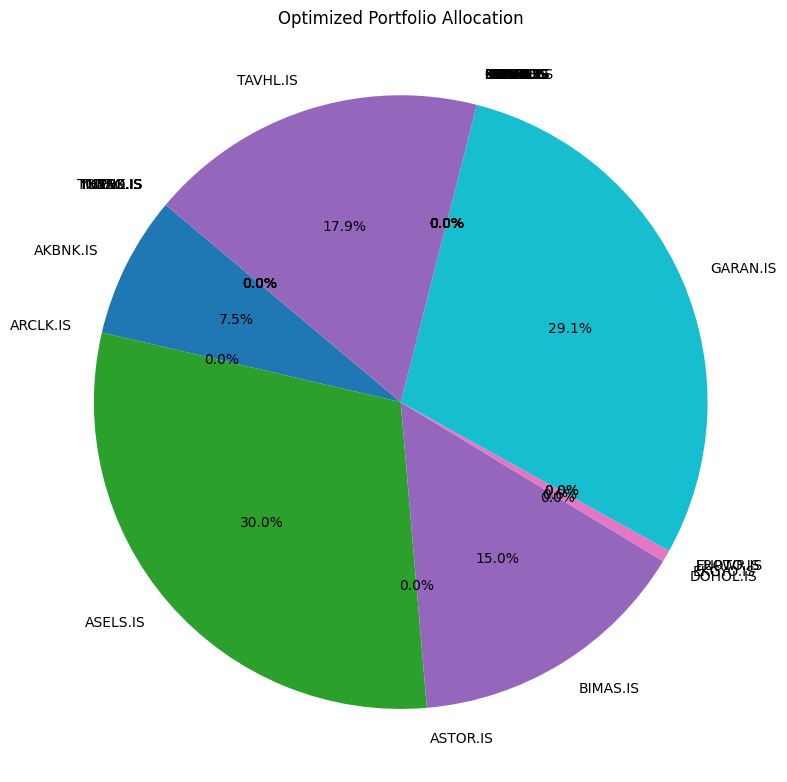

In [24]:
## Allocation Pie Chart ##

# Extracting cleaned weights
cleaned_weights = ef.clean_weights()
print("Optimized Portfolio Weights:\n", cleaned_weights)

# Plot pie chart of allocations
plt.figure(figsize=(8, 8))
plt.pie(cleaned_weights.values(), labels=cleaned_weights.keys(), autopct="%1.1f%%", startangle=140)
plt.title("Optimized Portfolio Allocation")
plt.axis("equal")
plt.tight_layout()
plt.show()


In [25]:
# Portfolio Performance Summary ##
expected_return, volatility, sharpe_ratio = ef.portfolio_performance()

print(f"Expected annual return: {expected_return:.2%}")
print(f"Annual volatility: {volatility:.2%}")
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")


Expected annual return: 101.49%
Annual volatility: 31.78%
Sharpe Ratio: 3.19
